In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from trl import SFTConfig, SFTTrainer

import warnings
warnings.filterwarnings("ignore")

/home/madhusudhanan.a/.conda/envs/vlm_ft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct"
EPOCHS = 3
BATCH_SIZE = 4
GRADIENT_CHECKPOINTING = True # Calculate intermediate activations again during the back propogation to save memorey (but computation time will increment)
USE_REENTRANT = False,
OPTIM = "paged_adamw_32bit"
LEARNING_RATE = 2e-5
LOGGING_STEPS = 50
EVAL_STEPS = 200
SAVE_STEPS = 200
EVAL_STRATEGY = "steps"
SAVE_STRATEGY = "steps"
METRIC_FOR_BEST_MODEL="eval_loss"
LOAD_BEST_MODEL_AT_END=True
MAX_GRAD_NORM = 1 # gradient clipping.
WARMUP_STEPS = 0
DATASET_KWARGS={"skip_prepare_dataset": True} # telling the trainer not to do any internal preprocessing or preparation
REMOVE_UNUSED_COLUMNS = False 
MAX_SEQ_LEN=128
NUM_STEPS = (283 // BATCH_SIZE) * EPOCHS
print(f"NUM_STEPS: {NUM_STEPS}")


Using device: cuda
NUM_STEPS: 210


In [3]:
system_message = """You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data. 
Your task is to process and extract meaningful insights from images, videos, and visual patterns, 
leveraging multimodal understanding to provide accurate and contextually relevant information."""

def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample["query"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["label"][0]}],
        },
    ]

In [4]:
train_dataset, eval_dataset,test_dataset = load_dataset("HuggingFaceM4/ChartQA",split=["train[:10%]", "val[:10%]", "test[:10%]"])

print(len(train_dataset))
print("-"*30)
print(train_dataset)
print("-"*30)
print(train_dataset[0])
print("-"*30)

train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

print(len(train_dataset))
print("-"*30)
print(train_dataset[0])
print("-"*30)
print(len(test_dataset))
print("-"*30)
print(test_dataset[0])                                                    

2830
------------------------------
Dataset({
    features: ['image', 'query', 'label', 'human_or_machine'],
    num_rows: 2830
})
------------------------------
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359 at 0x2BA77B31FBB0>, 'query': 'Is the value of Favorable 38 in 2015?', 'label': ['Yes'], 'human_or_machine': 0}
------------------------------
2830
------------------------------
[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data. \nYour task is to process and extract meaningful insights from images, videos, and visual patterns, \nleveraging multimodal understanding to provide accurate and contextually relevant information.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359 at 0x2BA87D415F90>}, {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]},

Two segments have the same percentage value, what's that value?
2


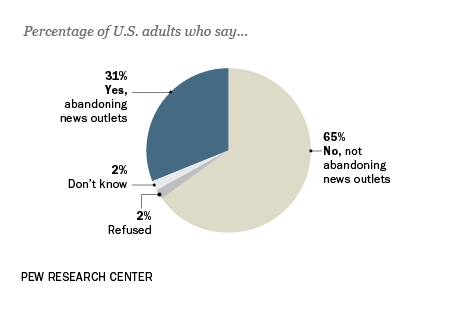

In [5]:
sample_data = test_dataset[15]
sample_question = sample_data[1]["content"][1]["text"]
sample_answer = sample_data[2]["content"][0]["text"]
sample_image = sample_data[1]["content"][0]["image"]

print(sample_question)
print(sample_answer)
sample_image

In [9]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,                      # Load model weights in 4-bit precision to reduce GPU memory usage
        bnb_4bit_use_double_quant=True,         # Apply double quantization: compress quantization constants too
        bnb_4bit_quant_type="nf4",              # Use 'nf4' (Normalized Float 4) for better accuracy in 4-bit quantization
        bnb_4bit_compute_dtype=torch.bfloat16   # Computation happens in bfloat16 (not 4-bit) for stability and speed
    )

    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",                      # Automatically map model parts to available devices (e.g., GPU)
        quantization_config=bnb_config,         # Apply the BitsAndBytes 4-bit quantization config
        use_cache=False                         # Disable KV (Key/Value) caching for attention layers; 
                                                # useful during training or when dynamic input lengths are used
    )
else:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID, 
        use_cache=False
        )
    
processor = Qwen2VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
def text_generator(sample_data):
  text = processor.apply_chat_template(sample_data[0:2], tokenize=False, add_generation_prompt = True)
  print(f"prompt: {text}")
  print("-"*30)

  image_inputs = sample_data[1]["content"][0]["image"]
  inputs = processor(text=[text],
                     images = image_inputs,
                     return_tensors="pt"
                     ).to(device)
  generated_ids = model.generate(**inputs, max_new_tokens=MAX_SEQ_LEN)
  output_text = processor.batch_decode(generated_ids,skip_special_tokens=True)
  del inputs
  actual_answer = sample_data[2]["content"][0]["text"]
  return output_text[0], actual_answer

generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")


prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data. 
Your task is to process and extract meaningful insights from images, videos, and visual patterns, 
leveraging multimodal understanding to provide accurate and contextually relevant information.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Two segments have the same percentage value, what's that value?<|im_end|>
<|im_start|>assistant

------------------------------
Generated Answer: system
You are a highly advanced Vision Language Model (VLM), specialized in analyzing, describing, and interpreting visual data. 
Your task is to process and extract meaningful insights from images, videos, and visual patterns, 
leveraging multimodal understanding to provide accurate and contextually relevant information.
user
Two segments have the same percentage value, what's that value?
assistant
50
Actual Answer: 2


In [11]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r = 8,
    bias = "none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM"
)

print(f"Before adapter parameters: {model.num_parameters()}")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters() 

Before adapter parameters: 2208985600
trainable params: 1,089,536 || all params: 2,210,075,136 || trainable%: 0.0493


In [12]:
training_args = SFTConfig(
    output_dir="./output",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    learning_rate=LEARNING_RATE,
    logging_steps=LOGGING_STEPS,
    eval_steps=EVAL_STEPS,
    eval_strategy=EVAL_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    max_grad_norm=MAX_GRAD_NORM,
    warmup_steps=WARMUP_STEPS,
    dataset_kwargs=DATASET_KWARGS,
    max_seq_length=MAX_SEQ_LEN,
    remove_unused_columns = REMOVE_UNUSED_COLUMNS,
    optim=OPTIM,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [13]:
from qwen_vl_utils import process_vision_info

collate_sample = [train_dataset[0], train_dataset[1]] # for batch size 2.

def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]  # Prepare texts for processing
    image_inputs = [process_vision_info(example)[0] for example in examples]  # Process the images to extract inputs

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)  # Encode texts and images into tensors

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels

    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):  # Check if the processor is Qwen2VLProcessor
        image_tokens = [151652, 151653, 151655]  # Specific image token IDs for Qwen2VLProcessor
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]  # Convert image token to ID

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels  # Add labels to the batch

    return batch  # Return the prepared batch




collated_data = collate_fn(collate_sample)
print(collated_data.keys())

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw', 'labels'])


In [14]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
print("-"*30)
print("Initial Evaluation")
metric = trainer.evaluate()
print(metric)
print("-"*30)

print("Training")
trainer.train()
print("-"*30)

In [ ]:
import gc
import time

# https://huggingface.co/learn/cookbook/en/fine_tuning_vlm_trl
def clear_memory():
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.00 GB
GPU reserved memory: 0.00 GB


In [15]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID, 
        device_map="auto", 
        quantization_config=bnb_config,
        use_cache=True
        )

else:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID, 
        use_cache=True
        )
    
processor = Qwen2VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


In [16]:
print(f"Before adapter parameters: {model.num_parameters()}")
model.load_adapter("/home/madhusudhanan.a/vlms/output/checkpoint-1000")
print(f"After adapter parameters: {model.num_parameters()}")

Before adapter parameters: 2208985600
After adapter parameters: 2210075136


In [ ]:
generated_text, actual_answer = text_generator(test_dataset[1])
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")